# Traffic Sign Recognition: Evaluation & Scaling Analysis
Leo Barnes
## Sections
1. Model Evaluation
2. Performance Visualization
3. Scaling Analysis (1000x data)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [2]:
import kagglehub #Load dataset

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
dataset_path = Path(path)

test_csv = pd.read_csv(dataset_path / "Test.csv")
train_csv = pd.read_csv(dataset_path / "Train.csv")

print(f"Train: {len(train_csv)}, Test: {len(test_csv)}, Classes: {train_csv['ClassId'].nunique()}")

Train: 39209, Test: 12630, Classes: 43


In [3]:
#Data set and data loader
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

class GTSRBDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(self.root_dir / row["Path"]).convert("RGB")
        label = row["ClassId"]
        if self.transform:
            img = self.transform(img)
        return img, label

test_dataset = GTSRBDataset(test_csv, root_dir=dataset_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f"Test loader: {len(test_loader)} batches")

Test loader: 198 batches


In [4]:
# Evaluation function
def evaluate_model(model, test_loader, device, model_name):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    start_time = time.time()
    total_images = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            total_images += images.size(0)
    
    inference_time = time.time() - start_time
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs_arr = np.array(all_probs)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    per_class_precision, per_class_recall, per_class_f1, per_class_support = \
        precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)
    
    top5_preds = np.argsort(all_probs_arr, axis=1)[:, -5:]
    top5_accuracy = np.mean([label in top5_preds[i] for i, label in enumerate(all_labels)])
    cm = confusion_matrix(all_labels, all_preds)
    throughput = total_images / inference_time
    
    print(f"\n{model_name}")
    print(f"  Accuracy: {accuracy:.4f} | Top-5: {top5_accuracy:.4f} | F1: {f1:.4f}")
    print(f"  Inference: {inference_time:.2f}s | Throughput: {throughput:.2f} img/s")
    
    return {
        'accuracy': accuracy, 'top5_accuracy': top5_accuracy, 'precision': precision,
        'recall': recall, 'f1': f1, 'per_class_precision': per_class_precision,
        'per_class_recall': per_class_recall, 'per_class_f1': per_class_f1,
        'per_class_support': per_class_support, 'confusion_matrix': cm,
        'predictions': all_preds, 'labels': all_labels, 'probabilities': all_probs_arr,
        'inference_time': inference_time, 'throughput': throughput, 'total_images': total_images
    }

In [5]:
# Evaluate models
os.makedirs('results', exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#ResNet
resnet_model = models.resnet18(weights=None)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 43)
resnet_model.load_state_dict(torch.load('/Users/ad/Desktop/data science/resnet18_traffic_signs.pth', map_location=device))
resnet_model.to(device).eval()

resnet_results = evaluate_model(resnet_model, test_loader, device, "ResNet-18")

# Clear GPU memory
del resnet_model
torch.cuda.empty_cache() if torch.cuda.is_available() else None


ResNet-18
  Accuracy: 0.6836 | Top-5: 0.9356 | F1: 0.6884
  Inference: 203.76s | Throughput: 61.98 img/s


In [6]:
# EfficientNet
from torchvision.models import efficientnet_b0

base_model = efficientnet_b0(weights=None) #Different architecture, so need to
base_model.classifier = nn.Identity()  # Remove classifier

efficientnet_model = nn.Sequential(base_model,
    nn.Linear(1280, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 43),
    nn.Softmax(dim=1)
)

# Load saved weights
efficientnet_model.load_state_dict(torch.load('/Users/ad/Desktop/data science/efficientnet_finetuned.pth', map_location=device))
efficientnet_model.to(device).eval()

efficientnet_results = evaluate_model(efficientnet_model, test_loader, device, "EfficientNet-B0")

del efficientnet_model
torch.cuda.empty_cache() if torch.cuda.is_available() else None


EfficientNet-B0
  Accuracy: 0.7313 | Top-5: 0.7946 | F1: 0.6645
  Inference: 742.97s | Throughput: 17.00 img/s


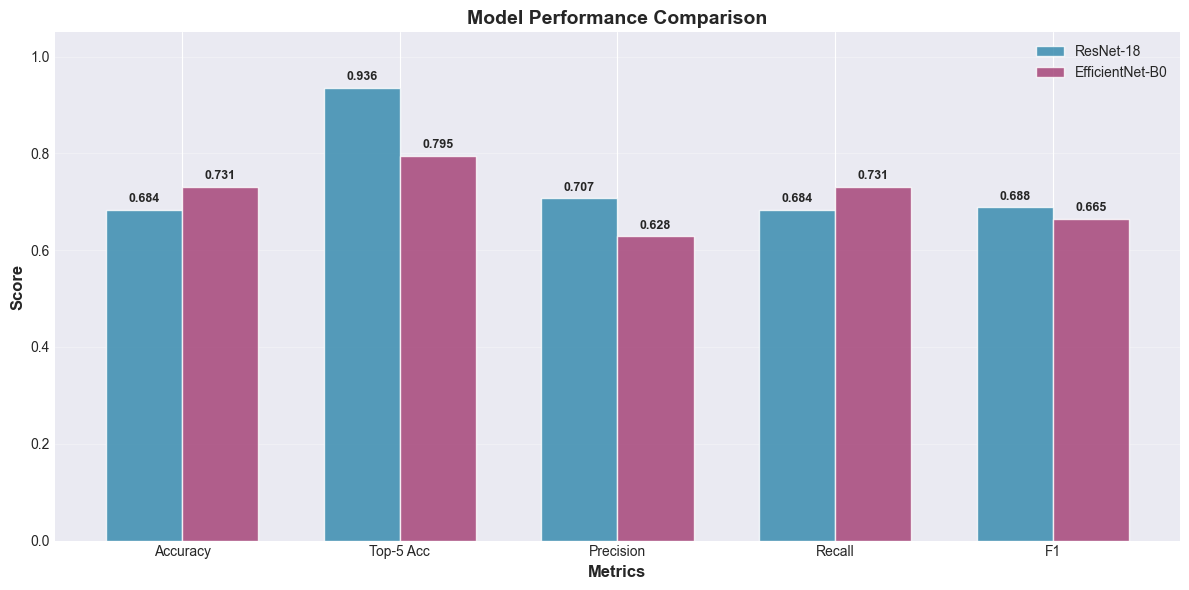

In [7]:
metrics = ['accuracy', 'top5_accuracy', 'precision', 'recall', 'f1'] #metrics we test
metric_labels = ['Accuracy', 'Top-5 Acc', 'Precision', 'Recall', 'F1']
resnet_scores = [resnet_results[m] for m in metrics]
efficientnet_scores = [efficientnet_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, resnet_scores, width, label='ResNet-18', alpha=0.8, color='#2E86AB')
bars2 = ax.bar(x + width/2, efficientnet_scores, width, label='EfficientNet-B0', alpha=0.8, color='#A23B72')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.legend()
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('results/01_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

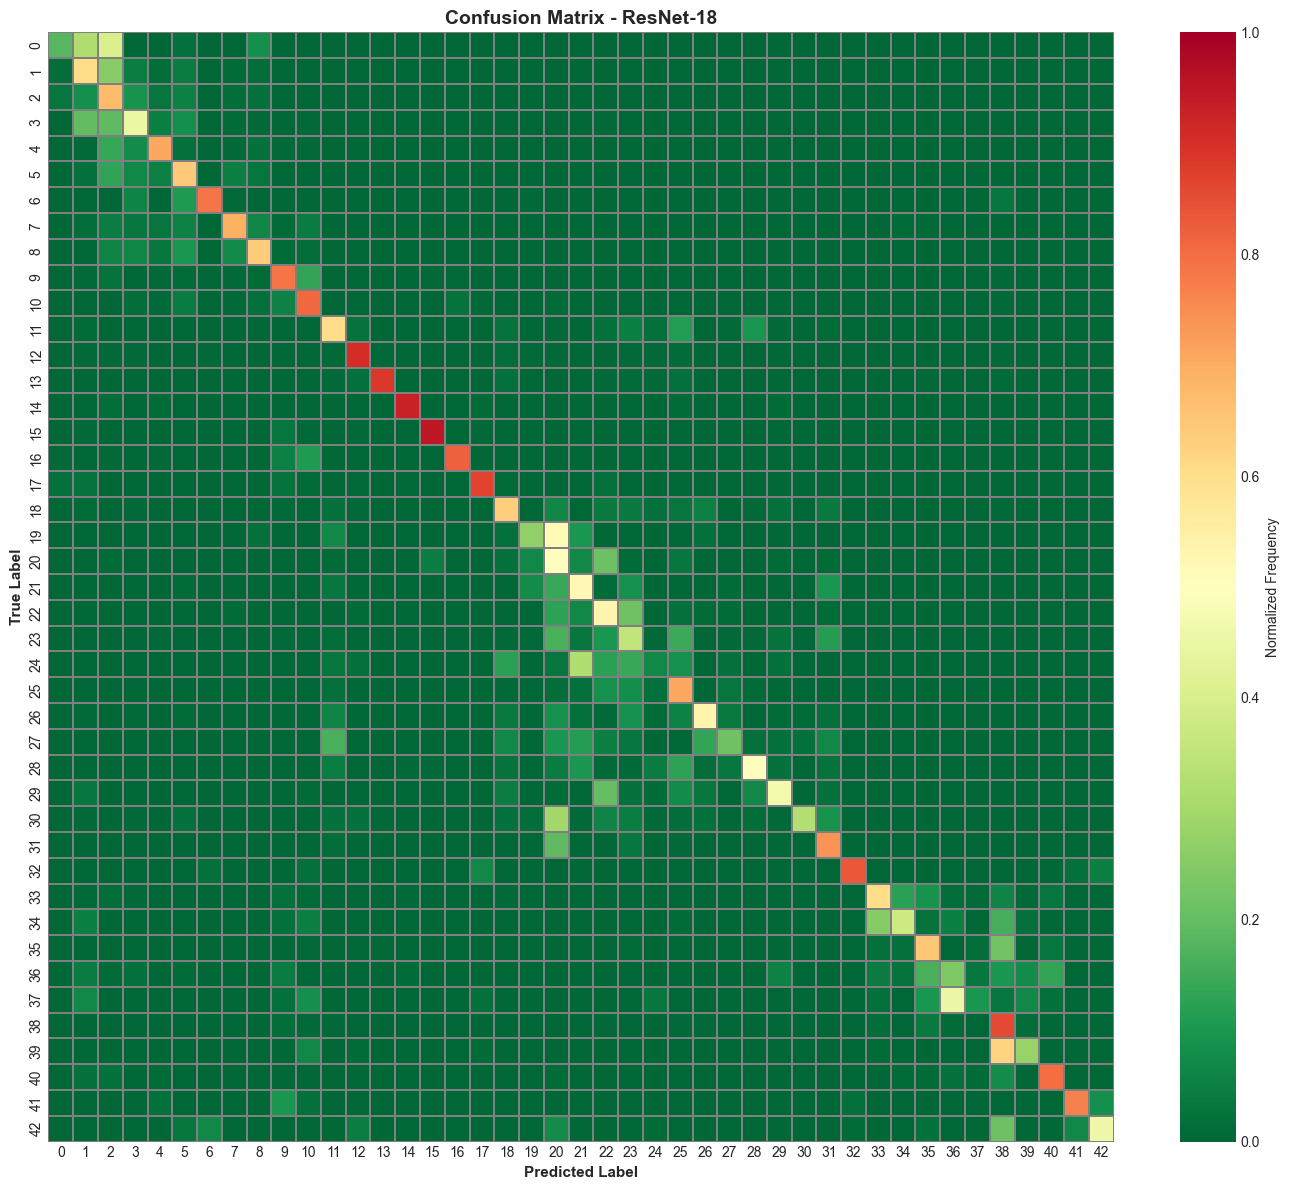


ResNet-18 - Top 10 Most Confused Pairs:
True   Pred   Rate       Count
39     38       62.2%      56
19     20       51.7%      31
37     36       45.0%      27
0      2        40.0%      24
24     21       32.2%      29
0      1        31.7%      19
30     20       29.3%      44
1      2        25.6%     184
34     33       25.0%      30
35     38       22.1%      86


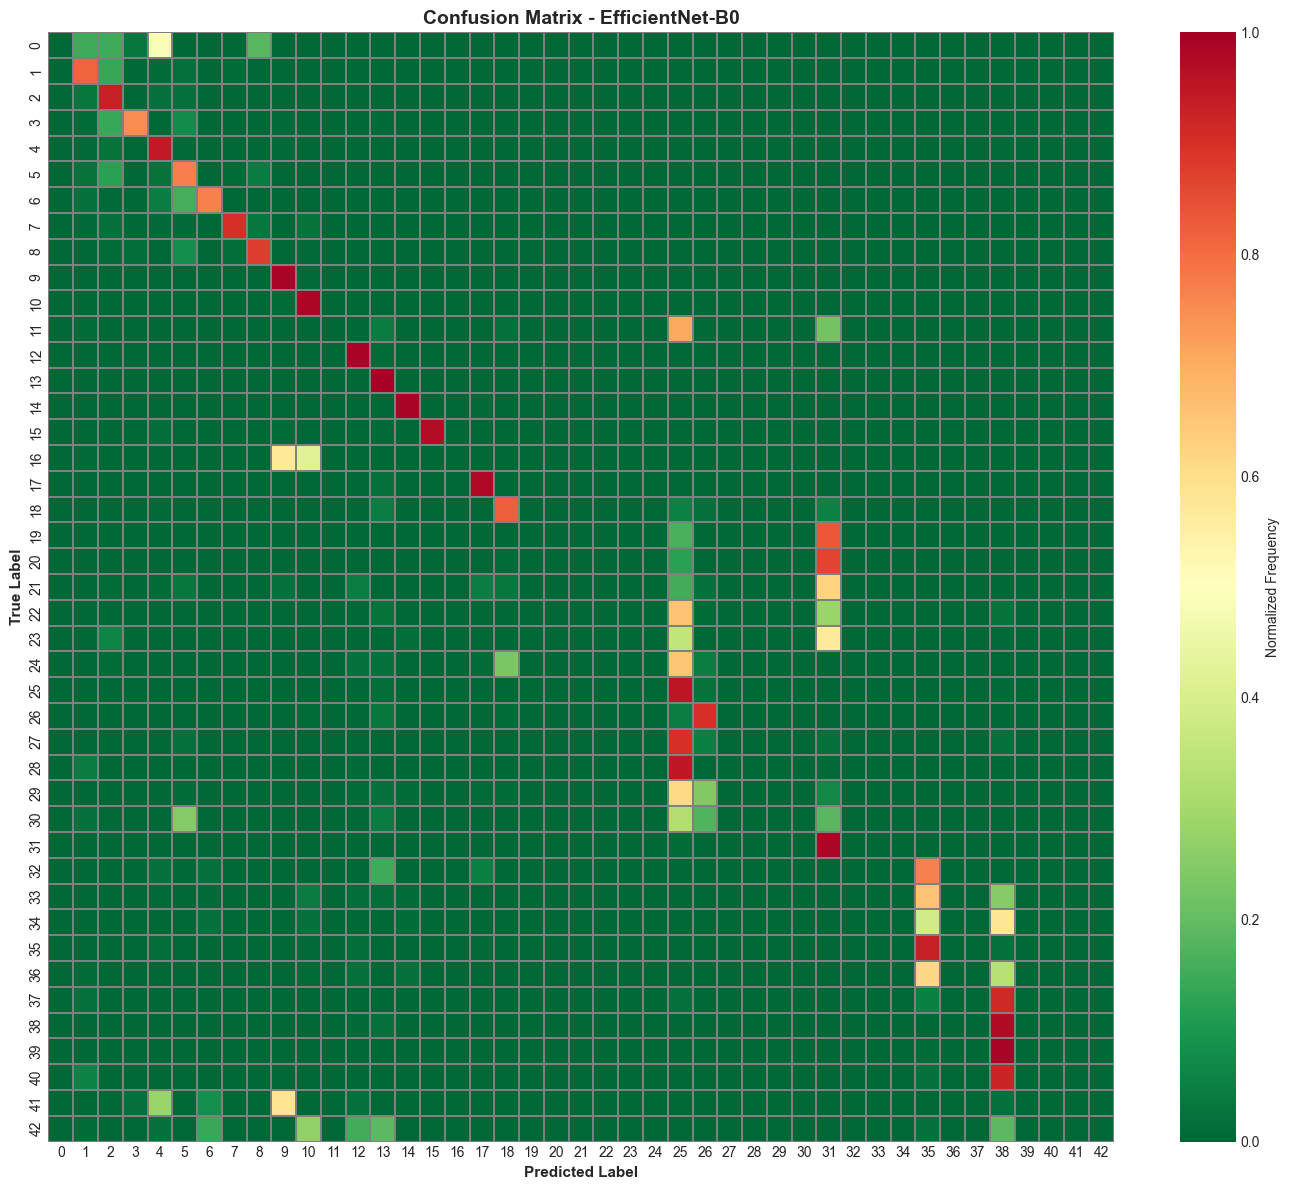


EfficientNet-B0 - Top 10 Most Confused Pairs:
True   Pred   Rate       Count
39     38       98.9%      89
28     25       94.7%     142
40     38       92.2%      83
37     38       91.7%      55
27     25       90.0%      54
20     31       86.7%      78
19     31       83.3%      50
32     35       76.7%      46
11     25       70.5%     296
22     25       65.8%      79


In [8]:
def plot_confusion_matrix(cm, model_name): #confusion matrices
    plt.figure(figsize=(14,12))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='RdYlGn_r', vmin=0, vmax=1,
                cbar_kws={'label': 'Normalized Frequency'}, linewidths=0.1, linecolor='gray')
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=11, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'results/02_confusion_{model_name.lower().replace(" ", "_").replace("-", "")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Most confused pairs
    confusion_pairs = [(i, j, cm_normalized[i, j], cm[i, j]) 
                       for i in range(cm.shape[0]) for j in range(cm.shape[0]) 
                       if i != j and cm_normalized[i, j] > 0.05]
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\n{model_name} - Top 10 Most Confused Pairs:")
    print(f"{'True':<6} {'Pred':<6} {'Rate':<10} {'Count'}")
    for true_c, pred_c, rate, count in confusion_pairs[:10]:
        print(f"{true_c:<6} {pred_c:<6} {rate:>7.1%}    {int(count):>4}")

plot_confusion_matrix(resnet_results['confusion_matrix'], "ResNet-18")
plot_confusion_matrix(efficientnet_results['confusion_matrix'], "EfficientNet-B0")

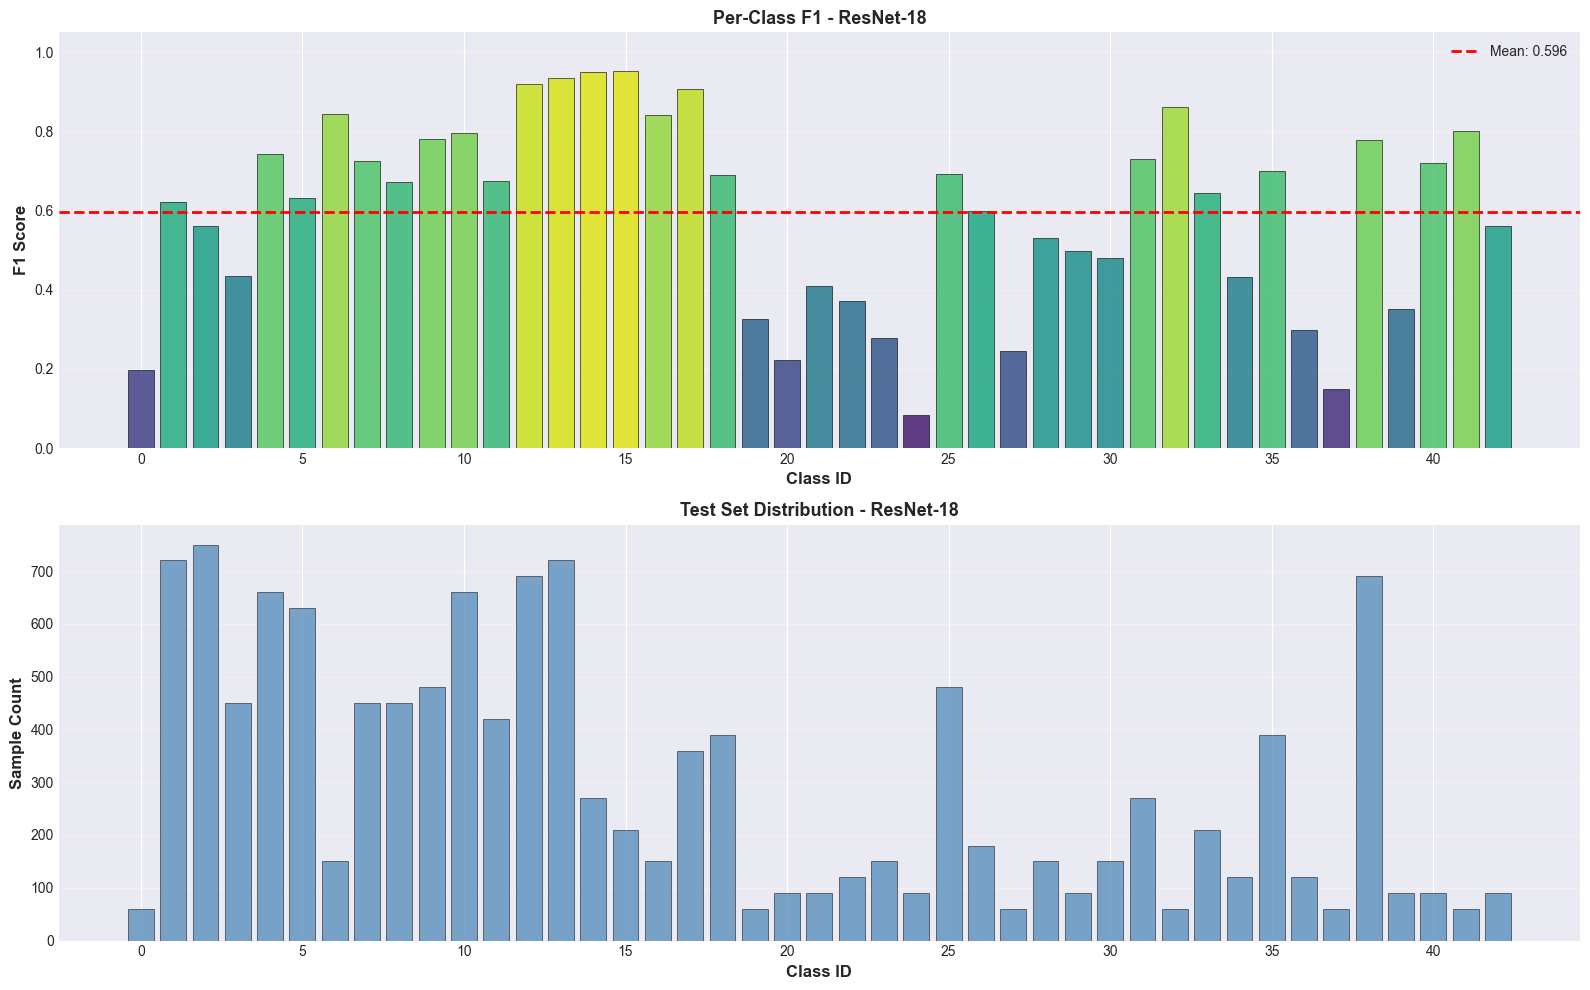


ResNet-18 - Worst 5 Classes:
  Class 24: F1=0.083, Precision=0.111, Recall=0.067
  Class 37: F1=0.148, Precision=0.286, Recall=0.100
  Class 0: F1=0.198, Precision=0.216, Recall=0.183
  Class 20: F1=0.223, Precision=0.143, Recall=0.500
  Class 27: F1=0.245, Precision=0.283, Recall=0.217

ResNet-18 - Best 5 Classes:
  Class 15: F1=0.952, Precision=0.952, Recall=0.952
  Class 14: F1=0.951, Precision=0.973, Recall=0.930
  Class 13: F1=0.934, Precision=0.989, Recall=0.885
  Class 12: F1=0.920, Precision=0.937, Recall=0.903
  Class 17: F1=0.906, Precision=0.946, Recall=0.869


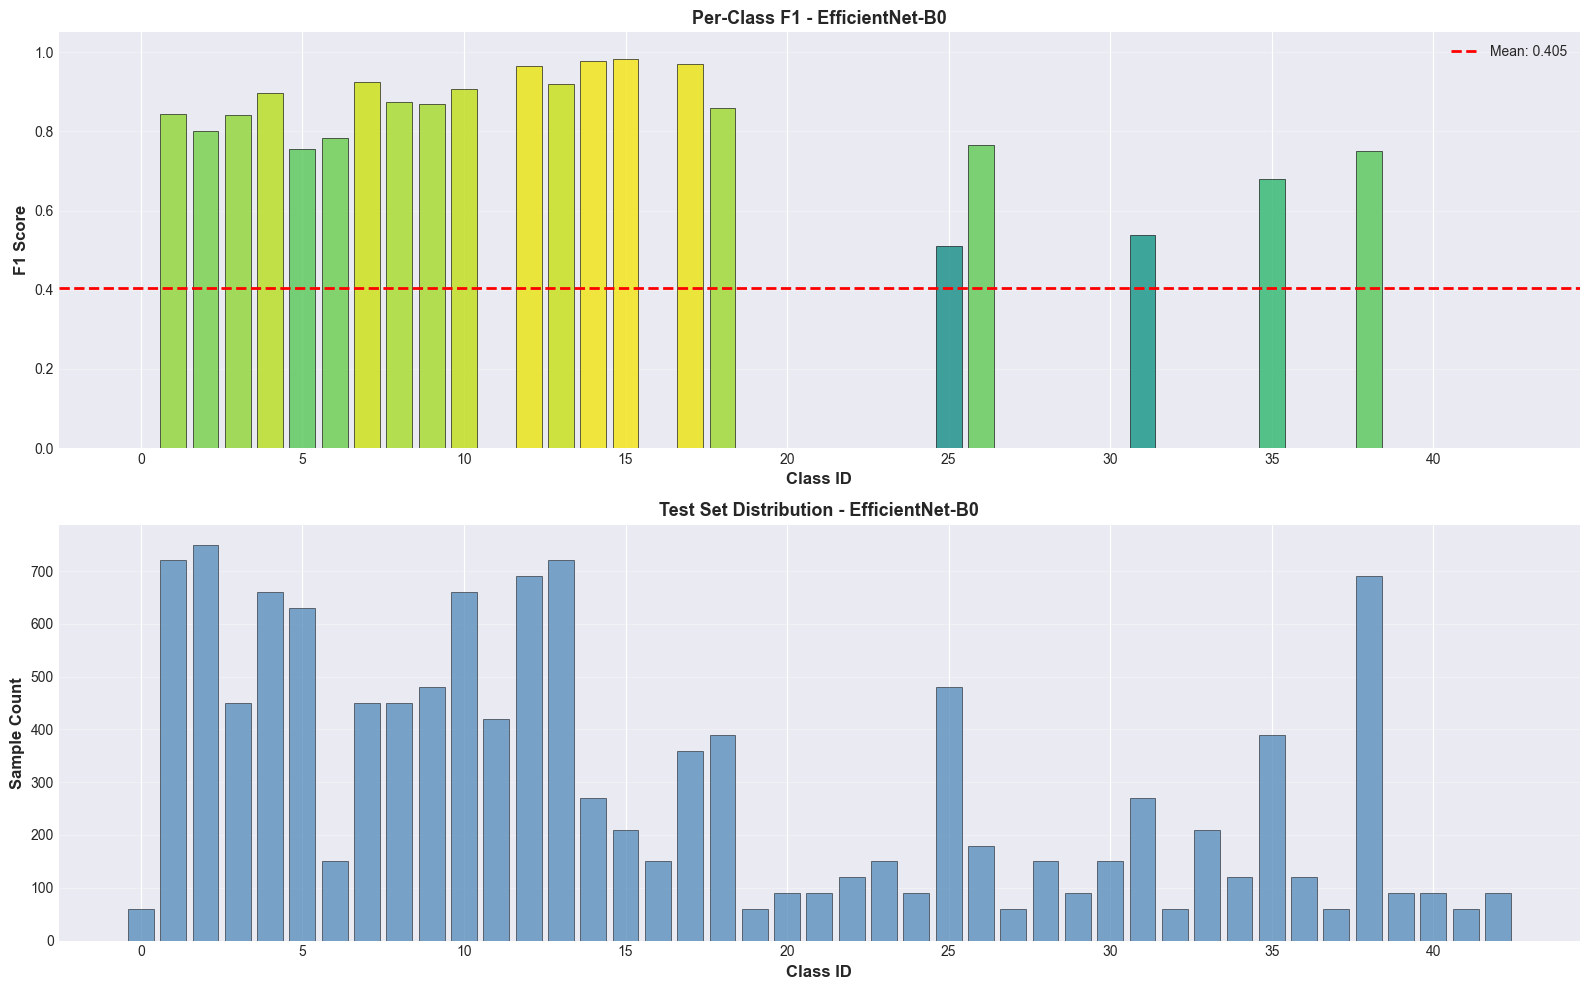


EfficientNet-B0 - Worst 5 Classes:
  Class 0: F1=0.000, Precision=0.000, Recall=0.000
  Class 41: F1=0.000, Precision=0.000, Recall=0.000
  Class 22: F1=0.000, Precision=0.000, Recall=0.000
  Class 23: F1=0.000, Precision=0.000, Recall=0.000
  Class 24: F1=0.000, Precision=0.000, Recall=0.000

EfficientNet-B0 - Best 5 Classes:
  Class 15: F1=0.983, Precision=0.995, Recall=0.971
  Class 14: F1=0.978, Precision=0.967, Recall=0.989
  Class 17: F1=0.971, Precision=0.964, Recall=0.978
  Class 12: F1=0.966, Precision=0.945, Recall=0.988
  Class 7: F1=0.925, Precision=0.949, Recall=0.902


In [9]:
def plot_per_class(results, model_name): # Performance per class
    n_classes = len(results['per_class_f1'])
    classes = range(n_classes)
    
    fig,(ax1, ax2) = plt.subplots(2,1,figsize=(16, 10))
    
    colors = plt.cm.viridis(results['per_class_f1'])
    ax1.bar(classes, results['per_class_f1'], color=colors, alpha=0.85, edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Class ID',fontsize=12,fontweight='bold')
    ax1.set_ylabel('F1 Score',fontsize=12,fontweight='bold')
    ax1.set_title(f'Per-Class F1 - {model_name}', fontsize=13, fontweight='bold')
    ax1.set_ylim([0, 1.05])
    ax1.axhline(y=results['per_class_f1'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {results["per_class_f1"].mean():.3f}')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_xticks(range(0, n_classes, 5))
    
    ax2.bar(classes, results['per_class_support'], color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Class ID', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
    ax2.set_title(f'Test Set Distribution - {model_name}', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_xticks(range(0, n_classes, 5))
    
    plt.tight_layout()
    plt.savefig(f'results/03_perclass_{model_name.lower().replace(" ", "_").replace("-", "")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    sorted_indices = np.argsort(results['per_class_f1'])
    print(f"\n{model_name} - Worst 5 Classes:")
    for idx in sorted_indices[:5]:
        print(f"  Class {idx}: F1={results['per_class_f1'][idx]:.3f}, "
              f"Precision={results['per_class_precision'][idx]:.3f}, "
              f"Recall={results['per_class_recall'][idx]:.3f}")
    
    print(f"\n{model_name} - Best 5 Classes:")
    for idx in sorted_indices[-5:][::-1]:
        print(f"  Class {idx}: F1={results['per_class_f1'][idx]:.3f}, "
              f"Precision={results['per_class_precision'][idx]:.3f}, "
              f"Recall={results['per_class_recall'][idx]:.3f}")

plot_per_class(resnet_results, "ResNet-18")
plot_per_class(efficientnet_results, "EfficientNet-B0")

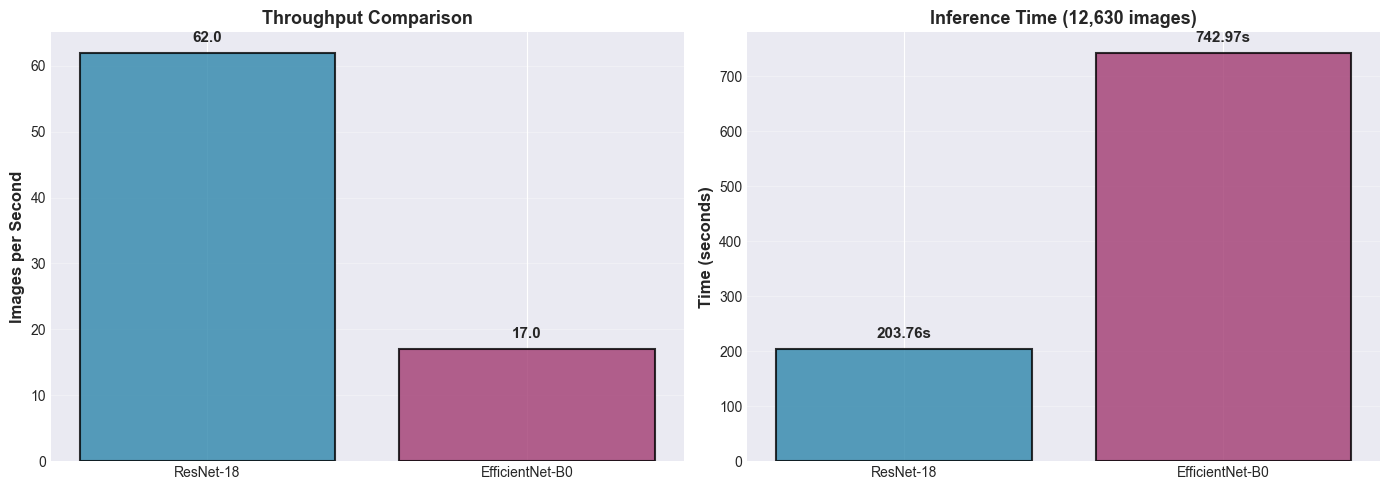

In [10]:
# Throughput comparison
models = ['ResNet-18', 'EfficientNet-B0']
throughputs = [resnet_results['throughput'], efficientnet_results['throughput']]
inference_times = [resnet_results['inference_time'], efficientnet_results['inference_time']]

fig,(ax1, ax2) = plt.subplots(1,2,figsize=(14,5))

bars1 = ax1.bar(models, throughputs, color=['#2E86AB', '#A23B72'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Images per Second', fontsize=12, fontweight='bold')
ax1.set_title('Throughput Comparison', fontsize=13, fontweight='bold')
ax1.grid(axis='y',alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(throughputs)*0.02,
            f'{height:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

bars2 = ax2.bar(models, inference_times, color=['#2E86AB', '#A23B72'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Inference Time (12,630 images)', fontsize=13, fontweight='bold')
ax2.grid(axis='y',alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(inference_times)*0.02,
            f'{height:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('results/04_throughput.png', dpi=300, bbox_inches='tight')
plt.show()


ResNet-18
  Errors: 3996/12630 (31.64%)
  Mean confidence on errors: 0.5256
  Mean confidence on correct: 0.7924


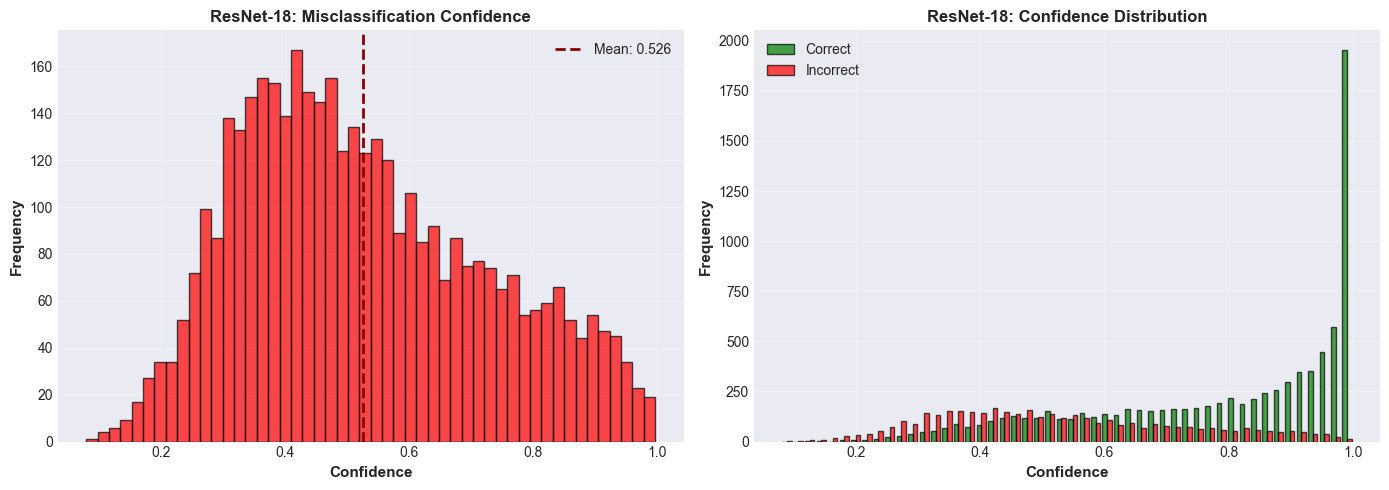


EfficientNet-B0
  Errors: 3394/12630 (26.87%)
  Mean confidence on errors: 0.0575
  Mean confidence on correct: 0.0604


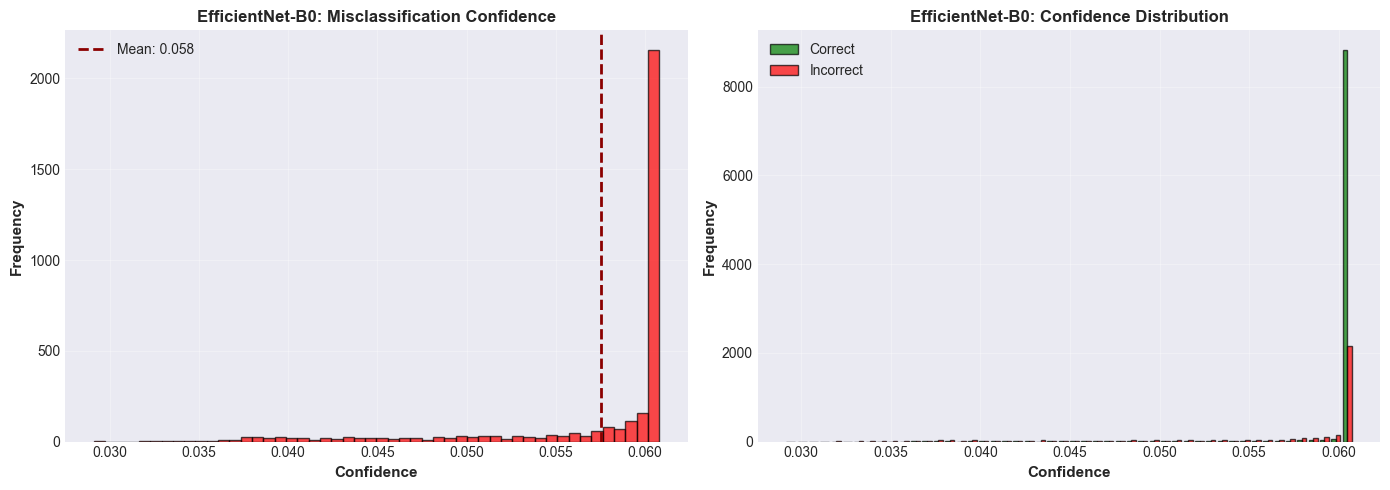

In [11]:
# Error analysis
def analyse_errors(results, model_name):
    predictions = np.array(results['predictions'])
    labels = np.array(results['labels'])
    probabilities = results['probabilities']
    
    errors = predictions != labels
    error_indices = np.where(errors)[0]
    correct_indices = np.where(~errors)[0]
    
    error_confidences = [probabilities[i][predictions[i]] for i in error_indices]
    correct_confidences = [probabilities[i][predictions[i]] for i in correct_indices]
    
    print(f"\n{model_name}")
    print(f"  Errors: {len(error_indices)}/{len(labels)} ({100*len(error_indices)/len(labels):.2f}%)")
    print(f"  Mean confidence on errors: {np.mean(error_confidences):.4f}")
    print(f"  Mean confidence on correct: {np.mean(correct_confidences):.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(error_confidences, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0].set_xlabel('Confidence', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0].set_title(f'{model_name}: Misclassification Confidence', fontsize=12, fontweight='bold')
    axes[0].axvline(np.mean(error_confidences), color='darkred', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(error_confidences):.3f}')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].hist([correct_confidences, error_confidences], bins=50, 
                label=['Correct', 'Incorrect'], alpha=0.7, color=['green', 'red'], edgecolor='black')
    axes[1].set_xlabel('Confidence', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[1].set_title(f'{model_name}: Confidence Distribution', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'results/05_error_{model_name.lower().replace(" ", "_").replace("-", "")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

analyse_errors(resnet_results, "ResNet-18")
analyse_errors(efficientnet_results, "EfficientNet-B0")

In [12]:
# Scaling analysis
def project_scaling(results, model_name, current_size=39209, scale_factor=1000): #1000 factor
    scaled_size = current_size * scale_factor
    time_per_image = results['inference_time'] / results['total_images']
    projected_time_hours = (scaled_size * time_per_image) / 3600
    
    print(f"\n{model_name} - 1000x Scaling")
    print(f"  Current: {current_size:,} images")
    print(f"  Scaled: {scaled_size:,} images")
    print(f"  Single GPU: {projected_time_hours:.2f} hours ({projected_time_hours/24:.2f} days)")
    print(f"\n  Multi-GPU (90% efficiency):")
    for n_gpus in [4, 8, 16, 32]:
        parallel_hours = projected_time_hours / (n_gpus * 0.90)
        print(f"    {n_gpus} GPUs: {parallel_hours:.2f} hours ({parallel_hours/24:.2f} days)")
    
    storage_tb = (scaled_size * 0.05 / 1024) / 1024
    print(f"\n  Storage: ~{storage_tb:.1f} TB")
    
    return {'scaled_size': scaled_size, 'projected_time_hours': projected_time_hours, 
            'time_per_image': time_per_image, 'storage_tb': storage_tb}

resnet_scaling = project_scaling(resnet_results, "ResNet-18", len(train_csv))
efficientnet_scaling = project_scaling(efficientnet_results, "EfficientNet-B0", len(train_csv))


ResNet-18 - 1000x Scaling
  Current: 39,209 images
  Scaled: 39,209,000 images
  Single GPU: 175.71 hours (7.32 days)

  Multi-GPU (90% efficiency):
    4 GPUs: 48.81 hours (2.03 days)
    8 GPUs: 24.40 hours (1.02 days)
    16 GPUs: 12.20 hours (0.51 days)
    32 GPUs: 6.10 hours (0.25 days)

  Storage: ~1.9 TB

EfficientNet-B0 - 1000x Scaling
  Current: 39,209 images
  Scaled: 39,209,000 images
  Single GPU: 640.70 hours (26.70 days)

  Multi-GPU (90% efficiency):
    4 GPUs: 177.97 hours (7.42 days)
    8 GPUs: 88.99 hours (3.71 days)
    16 GPUs: 44.49 hours (1.85 days)
    32 GPUs: 22.25 hours (0.93 days)

  Storage: ~1.9 TB


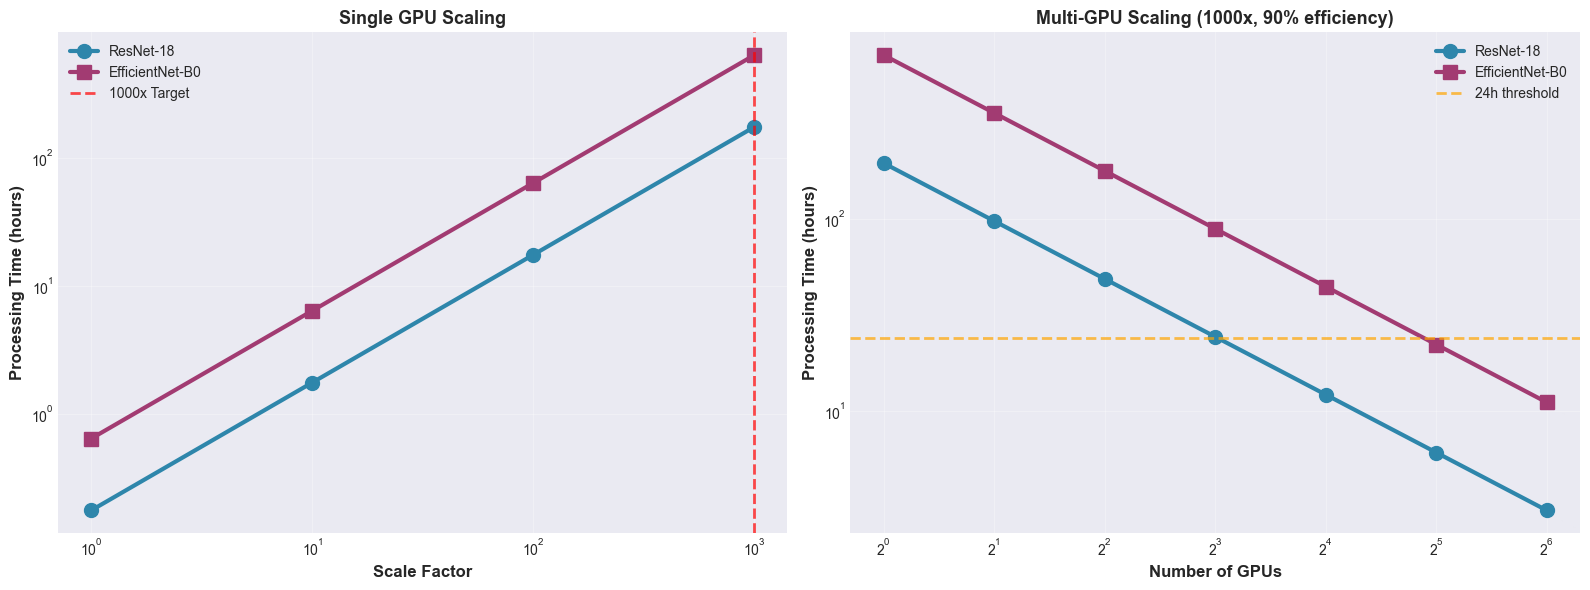

In [13]:
scale_factors = [1, 10, 100, 1000]
base_size = len(train_csv)

resnet_times = [resnet_scaling['time_per_image'] * base_size * sf / 3600 for sf in scale_factors]
efficientnet_times = [efficientnet_scaling['time_per_image'] * base_size * sf / 3600 for sf in scale_factors]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(scale_factors, resnet_times, 'o-', label='ResNet-18', linewidth=3, markersize=10, color='#2E86AB')
ax1.plot(scale_factors, efficientnet_times, 's-', label='EfficientNet-B0', linewidth=3, markersize=10, color='#A23B72')
ax1.axvline(x=1000, color='red', linestyle='--', linewidth=2, alpha=0.7, label='1000x Target')
ax1.set_xlabel('Scale Factor', fontsize=12, fontweight='bold')
ax1.set_ylabel('Processing Time (hours)', fontsize=12, fontweight='bold')
ax1.set_title('Single GPU Scaling', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

num_gpus = [1, 2, 4, 8, 16, 32, 64]
parallel_efficiency = 0.90
resnet_1000x = resnet_times[-1]
efficientnet_1000x = efficientnet_times[-1]
resnet_parallel = [resnet_1000x / (n * parallel_efficiency) for n in num_gpus]
efficientnet_parallel = [efficientnet_1000x / (n * parallel_efficiency) for n in num_gpus]

ax2.plot(num_gpus, resnet_parallel, 'o-', label='ResNet-18', linewidth=3, markersize=10, color='#2E86AB')
ax2.plot(num_gpus, efficientnet_parallel, 's-', label='EfficientNet-B0', linewidth=3, markersize=10, color='#A23B72')
ax2.axhline(y=24, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='24h threshold')
ax2.set_xlabel('Number of GPUs', fontsize=12, fontweight='bold')
ax2.set_ylabel('Processing Time (hours)', fontsize=12, fontweight='bold')
ax2.set_title('Multi-GPU Scaling (1000x, 90% efficiency)', fontsize=13, fontweight='bold')
ax2.set_xscale('log', base=2)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('results/06_scaling.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
overall_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Top-5 Accuracy', 'Precision', 'Recall', 'F1-Score', 
               'Throughput (img/s)', 'Inference Time (s)'],
    'ResNet-18': [
        f"{resnet_results['accuracy']:.4f}",
        f"{resnet_results['top5_accuracy']:.4f}",
        f"{resnet_results['precision']:.4f}",
        f"{resnet_results['recall']:.4f}",
        f"{resnet_results['f1']:.4f}",
        f"{resnet_results['throughput']:.2f}",
        f"{resnet_results['inference_time']:.2f}"],
    'EfficientNet-B0': [
        f"{efficientnet_results['accuracy']:.4f}",
        f"{efficientnet_results['top5_accuracy']:.4f}",
        f"{efficientnet_results['precision']:.4f}",
        f"{efficientnet_results['recall']:.4f}",
        f"{efficientnet_results['f1']:.4f}",
        f"{efficientnet_results['throughput']:.2f}",
        f"{efficientnet_results['inference_time']:.2f}"]
})
overall_metrics.to_csv('results/overall_metrics.csv', index=False)

for name, results in [('resnet18', resnet_results), ('efficientnet_b0', efficientnet_results)]:
    pd.DataFrame({
        'Class_ID': range(43),
        'Precision': results['per_class_precision'],
        'Recall': results['per_class_recall'],
        'F1_Score': results['per_class_f1'],
        'Support': results['per_class_support'].astype(int)
    }).to_csv(f'results/per_class_{name}.csv', index=False)

print("Exported to CSV")

Exported to CSV
